## O1 EXPLORATORY DATA ANALYSIS

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [60]:
in_state = pd.read_csv("../DATA/In_State_UVA_Tuition.csv")
out_state = pd.read_csv("../DATA/Out_Of_State_UVA_Tuition.csv")

print("In-State Tuition Data:")
print(in_state.head(), "\n")
print("Out-of-State Tuition Data:")
print(out_state.head(), "\n")

In-State Tuition Data:
      Year  Residency      Totals Required Fees     Tuition
0  2023-24   In-State  $21,123.00     $3,496.00  $17,627.00
1  2022-23   In-State  $20,330.00     $3,350.00  $16,980.00
2  2021-22   In-State  $19,244.00     $3,234.00  $16,010.00
3  2020-21   In-State  $18,948.00     $3,108.00  $15,840.00
4  2019-20   In-State  $17,786.00     $2,950.00  $14,836.00 

Out-of-State Tuition Data:
      Year     Residency      Totals Required Fees     Tuition
0  2023-24  Out-of-State  $58,014.00     $4,178.00  $53,836.00
1  2022-23  Out-of-State  $55,902.00     $4,032.00  $51,870.00
2  2021-22  Out-of-State  $53,626.00     $3,916.00  $49,710.00
3  2020-21  Out-of-State  $52,831.00     $3,790.00  $49,041.00
4  2019-20  Out-of-State  $50,889.00     $3,632.00  $47,257.00 



In [61]:
print("In-State Dataset Info:")
print(in_state.info(), "\n")
print(in_state.describe(include="all"), "\n")


print("Out-of-State Dataset Info:")
print(out_state.info(), "\n")
print(out_state.describe(include="all"), "\n")

In-State Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           54 non-null     object
 1   Residency      54 non-null     object
 2   Totals         54 non-null     object
 3   Required Fees  54 non-null     object
 4   Tuition        54 non-null     object
dtypes: object(5)
memory usage: 2.2+ KB
None 

           Year  Residency      Totals Required Fees    Tuition
count        54         54          54            54         54
unique       54          1          54            53         46
top     2023-24   In-State  $21,123.00       $279.00  $3,832.00
freq          1         54           1             2          4 

Out-of-State Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         -------------

In [62]:
print("Missing values in In-State:")
print(in_state.isnull().sum(), "\n")

print("Missing values in Out-of-State:")
print(out_state.isnull().sum(), "\n")

print("Duplicate rows in In-State:", in_state.duplicated().sum())
print("Duplicate rows in Out-of-State:", out_state.duplicated().sum(), "\n")

Missing values in In-State:
Year             0
Residency        0
Totals           0
Required Fees    0
Tuition          0
dtype: int64 

Missing values in Out-of-State:
Year             0
Residency        0
Totals           0
Required Fees    0
Tuition          0
dtype: int64 

Duplicate rows in In-State: 0
Duplicate rows in Out-of-State: 0 



In [63]:
def clean_single_dataset(df):
    # --- 1️⃣ Clean and standardize the Year column ---
    # Extract first 4 digits (handles formats like '1970-71', '1970–71', '1970/71')
    df["Year_Start"] = (
        df["Year"]
        .astype(str)
        .str.extract(r"(\d{4})")[0]       # extract first 4-digit sequence
        .astype(float)                    # temporary float for NaN handling
    )

    # Drop rows where year is missing
    df = df.dropna(subset=["Year_Start"])
    df["Year_Start"] = df["Year_Start"].astype(int)

    # --- 2️⃣ Clean all numeric columns except Residency ---
    for col in df.columns:
        if col not in ["Residency", "Year", "Year_Start"]:
            df[col] = (
                df[col]
                .astype(str)
                .replace(r"[\$,]", "", regex=True)
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # --- 3️⃣ Recalculate Tuition if missing ---
    if "Tuition" in df.columns and df["Tuition"].isnull().sum() > 0:
        if "Totals" in df.columns and "Required Fees" in df.columns:
            df["Tuition"] = df["Totals"] - df["Required Fees"]

    # --- 4️⃣ Sort by Year_Start ---
    df = df.sort_values("Year_Start").reset_index(drop=True)

    return df


# -----------------------------
# Apply to both datasets
# -----------------------------
in_state = clean_single_dataset(in_state)
out_state = clean_single_dataset(out_state)

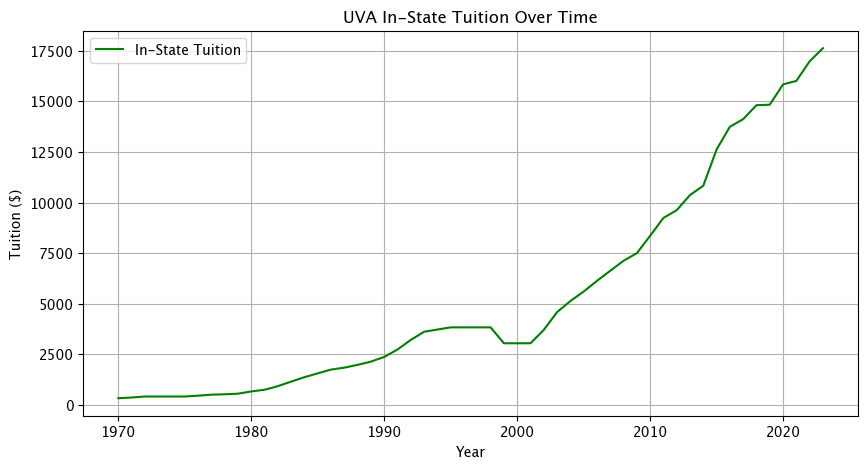

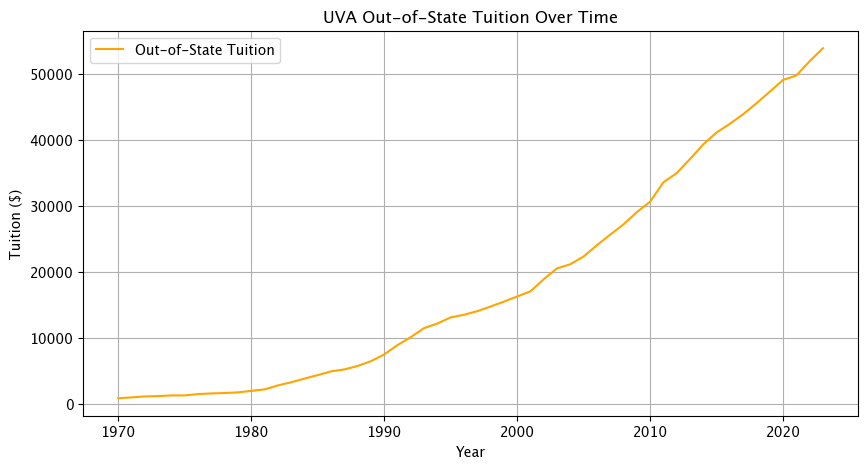

In [64]:
plt.figure(figsize=(10,5))
plt.plot(in_state["Year_Start"], in_state["Tuition"], label="In-State Tuition", color="green")
plt.title("UVA In-State Tuition Over Time")
plt.xlabel("Year")
plt.ylabel("Tuition ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(out_state["Year_Start"], out_state["Tuition"], label="Out-of-State Tuition", color="orange")
plt.title("UVA Out-of-State Tuition Over Time")
plt.xlabel("Year")
plt.ylabel("Tuition ($)")
plt.legend()
plt.grid(True)
plt.show()

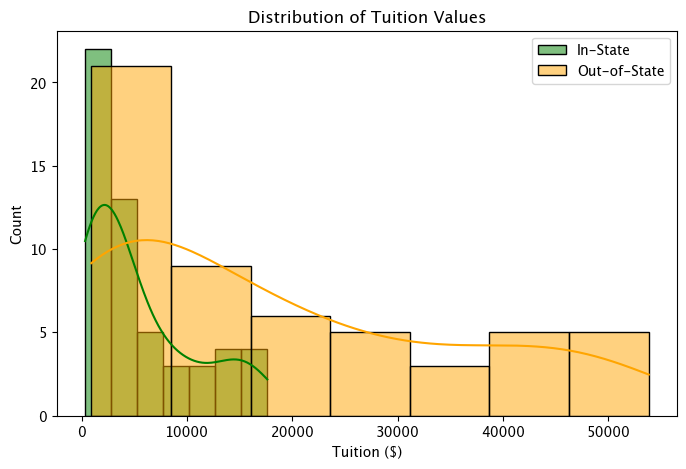

In [65]:
plt.figure(figsize=(8,5))
sns.histplot(in_state["Tuition"], kde=True, color="green", label="In-State")
sns.histplot(out_state["Tuition"], kde=True, color="orange", label="Out-of-State")
plt.title("Distribution of Tuition Values")
plt.xlabel("Tuition ($)")
plt.legend()
plt.show()

In [66]:
merged = pd.merge(
    in_state,
    out_state,
    on="Year_Start",
    suffixes=("_InState", "_OutState")
)

# Compute Tuition Gap
merged["Tuition_Gap"] = merged["Tuition_OutState"] - merged["Tuition_InState"]

# Sort and reset index
merged = merged.sort_values("Year_Start").reset_index(drop=True)

print("Merged Dataset Preview:")
print(merged.head(), "\n")

print("Missing values in merged data:")
print(merged.isnull().sum(), "\n")

print("Duplicate rows in merged data:", merged.duplicated().sum(), "\n")

Merged Dataset Preview:
  Year_InState Residency_InState  Totals_InState  Required Fees_InState  \
0      1970-71          In-State           484.0                  154.0   
1      1971-72          In-State           537.0                  172.0   
2      1972-73          In-State           597.0                  182.0   
3      1973-74          In-State           622.0                  207.0   
4      1974-75          In-State           644.0                  229.0   

   Tuition_InState  Year_Start Year_OutState Residency_OutState  \
0            330.0        1970       1970-71       Out-of-State   
1            365.0        1971       1971-72       Out-of-State   
2            415.0        1972       1972-73       Out-of-State   
3            415.0        1973       1973-74       Out-of-State   
4            415.0        1974       1974-75       Out-of-State   

   Totals_OutState  Required Fees_OutState  Tuition_OutState  Tuition_Gap  
0           1069.0                   154.0    

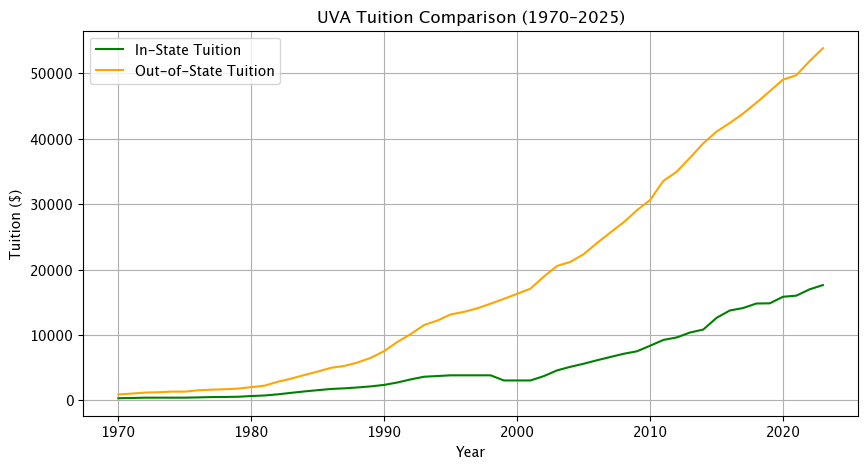

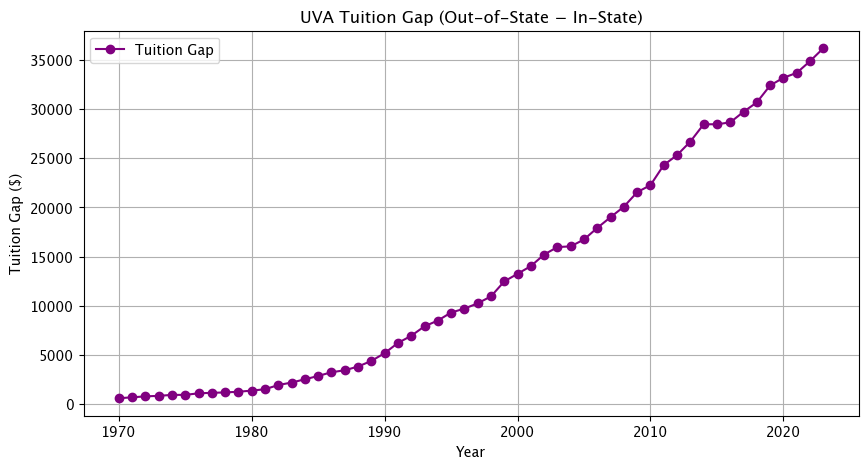

In [67]:
plt.figure(figsize=(10,5))
plt.plot(merged["Year_Start"], merged["Tuition_InState"], label="In-State Tuition", color="green")
plt.plot(merged["Year_Start"], merged["Tuition_OutState"], label="Out-of-State Tuition", color="orange")
plt.title("UVA Tuition Comparison (1970–2025)")
plt.xlabel("Year")
plt.ylabel("Tuition ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(merged["Year_Start"], merged["Tuition_Gap"], label="Tuition Gap", color="purple", marker="o")
plt.title("UVA Tuition Gap (Out-of-State − In-State)")
plt.xlabel("Year")
plt.ylabel("Tuition Gap ($)")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
merged.to_csv("../DATA/Combined_UVA_Tuition_Cleaned.csv", index=False)